In [3]:
%matplotlib notebook

In [25]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from skimage.feature import canny
from skimage.draw import circle
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

        
def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)
    edges = np.nonzero(canny(label_image.astype(np.float)))
    ax.plot(edges[1],edges[0],'.b',markersize=3)
    ax.axis('image')
    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

def read_noise_covariance_matrix(filename):
    f = open(filename,'rb')
    xml_length = np.fromfile(f,dtype=np.uint32,count=1)
    xml_header = f.read(xml_length)
    noise_dwell_time = np.fromfile(f,dtype=np.float32,count=1)
    cov_length = np.fromfile(f,dtype=np.uint64,count=1)
    ndim = np.fromfile(f,dtype=np.uint64,count=1)
    dims = np.fromfile(f,dtype=np.uint64,count=ndim)
    cov_mtx = np.fromfile(f,dtype=np.complex64,count=np.prod(dims))
    cov_mtx = cov_mtx.reshape(dims)
    f.close()
    return cov_mtx

In [21]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_PANDA/DAY6_SPIRAL_SNR/DICOM')
print_dicom_summary(d)

15	1	CART_BW1002_TR0268__GT
16	1	CART_BW1002_TR0268__GT_SNR_MAP
17	1	CART_BW1002_TR0268__GT_Noise_SD_Plot
30	50	SPIR_BW360_TR0360_I96__GT
31	1	SPIR_BW360_TR0360_I96__GT_SNR_MAP
32	50	SPIR_BW250_TR0529_I64__GT
33	1	SPIR_BW250_TR0529_I64__GT_SNR_MAP
34	50	SPIR_BW210_TR0713_I48__GT
35	1	SPIR_BW210_TR0713_I48__GT_SNR_MAP
36	50	SPIR_BW180_TR1084_I32__GT
37	1	SPIR_BW180_TR1084_I32__GT_SNR_MAP
38	50	SPIR_BW160_TR2166_I16__GT
39	1	SPIR_BW160_TR2166_I16__GT_SNR_MAP
40	50	SPIR_BW150_TR4341_I8__GT
41	1	SPIR_BW150_TR4341_I8__GT_SNR_MAP
42	51	SPIR_BW500_TR1459_I8__GT
43	1	SPIR_BW500_TR1459_I8__GT_SNR_MAP


In [22]:
snr_images = [16,31,33,35,37,39,41,43]

<IPython.core.display.Javascript object>


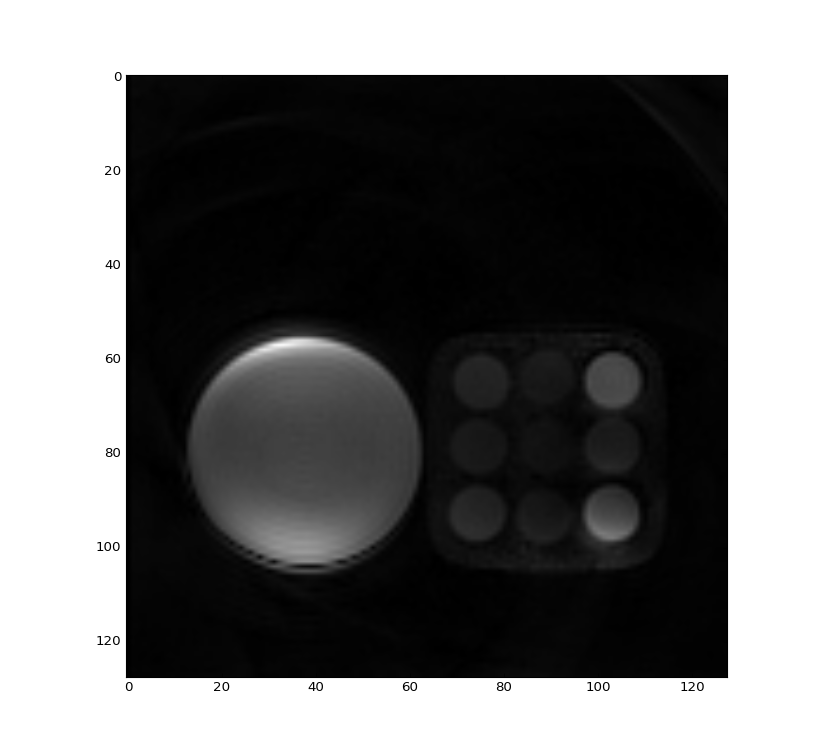

In [27]:
f, ax = plt.subplots(1,1)
img1 = ax.imshow(d[42][0].pixel_array,cmap=plt.cm.gray)

In [28]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        f.canvas.mpl_disconnect(cid)

cid = f.canvas.mpl_connect('button_press_event', onclick)


In [30]:
coords

[(37.968750000000007, 78.927083333333343),
 (75.302083333333343, 64.927083333333343),
 (89.635416666666686, 64.59375),
 (102.96875, 64.927083333333343),
 (74.96875, 78.59375),
 (88.394946808510625, 78.453457446808528),
 (102.86303191489358, 78.027925531914917),
 (74.139627659574458, 92.708776595744695),
 (88.182180851063805, 93.347074468085111),
 (103.50132978723403, 93.134308510638306)]

In [31]:
stored_coords = [(37.968750000000007, 78.927083333333343),
 (75.302083333333343, 64.927083333333343),
 (89.635416666666686, 64.59375),
 (102.96875, 64.927083333333343),
 (74.96875, 78.59375),
 (88.394946808510625, 78.453457446808528),
 (102.86303191489358, 78.027925531914917),
 (74.139627659574458, 92.708776595744695),
 (88.182180851063805, 93.347074468085111),
 (103.50132978723403, 93.134308510638306)]

In [32]:
coords = stored_coords

In [33]:
radius = 3
labels = np.zeros(d[42][0].pixel_array.shape,dtype=np.int)
for idx,c in enumerate(coords):
    cc,rr = circle(c[1],c[0],radius)
    labels[cc,rr] = idx+1


<IPython.core.display.Javascript object>


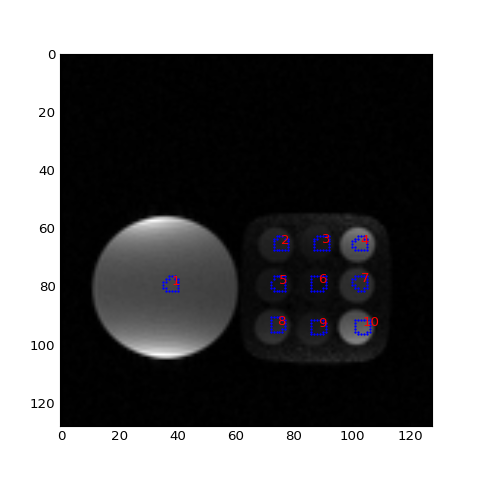

In [34]:
display_labels_on_image(d[16][0].pixel_array,labels)

```
data_meas_MID00194_FID02862_CART_BW1002_TR0268.dat.h5
dwell_time = 3.9
samples = 256

data_meas_MID00207_FID02875_SPIR_BW360_TR0360_I96.dat.h5
dwell_time = 10.9
samples = 154


data_meas_MID00208_FID02876_SPIR_BW250_TR0529_I64.dat.h5
dwell_time = 15.6
samples = 216


data_meas_MID00209_FID02877_SPIR_BW210_TR0713_I48.dat.h5
dwell_time = 18.6
samples = 280

data_meas_MID00210_FID02878_SPIR_BW180_TR1084_I32.dat.h5
dwell_time = 21.7
samples = 410


data_meas_MID00211_FID02879_SPIR_BW160_TR2166_I16.dat.h5
dwell_time = 24.4
samples = 808

data_meas_MID00212_FID02880_SPIR_BW150_TR4341_I8.dat.h5
dwell_time = 26.0
samples = 1610

data_meas_MID00213_FID02881_SPIR_BW500_TR1459_I8.dat.h5
dwell_time = 7.8
samples = 1626
```

In [10]:
dwell_times = np.array([3.9,10.9,15.6,18.8,21.7,24.4,26.0,7.8])
samples = np.array([256,154,216,280,410,808,1610,1626])
TR = np.array([2.68,3.6,5.29,7.13,10.84,21.66,43.41,14.59])
lines = np.array([128,96,64,48,32,16,8,8])
total_sample_time = (dwell_times/1000.0)*samples*lines

In [11]:
total_sample_time

array([ 127.7952,  161.1456,  215.6544,  252.672 ,  284.704 ,  315.4432,
        334.88  ,  101.4624])

In [12]:
snr_values = np.zeros((dwell_times.shape[0],10),dtype=float)

for idx, im in enumerate(snr_images):
    snr_values[idx,:] = get_label_mean(d[im][0].pixel_array,labels,range(1,11))

In [13]:
rel_sample_time = [x/total_sample_time[1] for x in total_sample_time]

rel_snr = snr_values / snr_values[1:2,:]


In [14]:
np.sqrt(rel_sample_time)

array([ 0.89052896,  1.        ,  1.15683105,  1.25218741,  1.32919151,
        1.39910838,  1.44156882,  0.79349344])

In [15]:
rel_snr[:,0]

array([ 0.50171294,  1.        ,  1.17126171,  1.22591275,  1.83552481,
        1.37599922,  1.81222878,  0.71793533])

In [16]:
r = 1
((np.pi*r**2)/(4*r**2))
np.sqrt(0.7853981633974483*0.79304182056475625)

0.78921073824988486

In [17]:
np.sqrt(0.78*0.79)

0.78498407627161459

In [18]:
0.5/0.78

0.641025641025641

In [19]:
snr_values[1,:]

array([ 1178.80769231,   543.40740741,   353.03846154,  1461.62068966,
         362.2962963 ,   245.37931034,   645.37931034,   716.68965517,
         482.66666667,  1605.62068966])

In [191]:
591/1026

0.5760233918128655

In [192]:
rel_sample_time

[0.79304182056475625,
 1.0,
 1.3382580722030262,
 1.5679733110925773,
 1.766750069502363,
 1.9575042694308749,
 2.0781206561023073,
 0.62963183605385442]

In [199]:
import h5py

In [201]:
out = h5py.File('/home/hansenms/data/PANDA/NIH_PANDA/DAY6_SPIRAL_SNR/DAT/out.h5')

In [216]:
img_it = np.flipud(np.squeeze(np.asarray(out['I96/image_300/data'],dtype=np.float)))

In [221]:
get_label_mean(img_it,labels,range(1,11))

[1030.3461538461538,
 456.96296296296299,
 315.03846153846155,
 1225.344827586207,
 304.77777777777777,
 220.89655172413794,
 551.82758620689651,
 604.9655172413793,
 411.44444444444446,
 1355.4482758620691]

In [218]:
snr_values[1,:]

array([ 1178.80769231,   543.40740741,   353.03846154,  1461.62068966,
         362.2962963 ,   245.37931034,   645.37931034,   716.68965517,
         482.66666667,  1605.62068966])

In [224]:
snr_values[1,:]/get_label_mean(img_it,labels,range(1,11))

array([ 1.14408899,  1.18917166,  1.12062019,  1.19282398,  1.18872281,
        1.11083359,  1.16953071,  1.18467852,  1.17310289,  1.18456803])

<IPython.core.display.Javascript object>


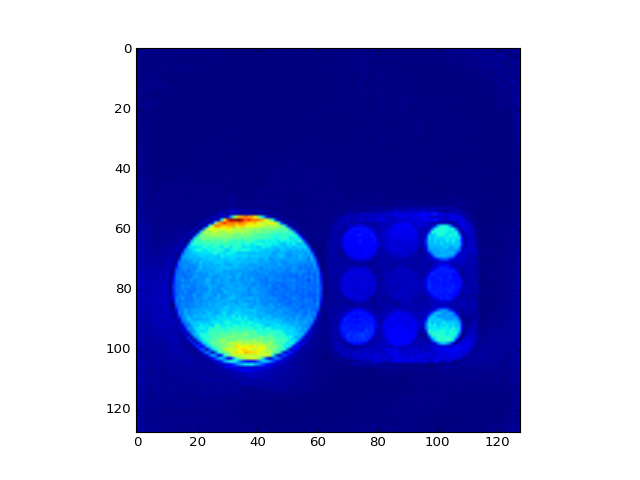

In [219]:
f, ax = plt.subplots(1,1)
img1 = ax.imshow(img_it,cmap=plt.cm.jet)